# Simulations on Real Data from Fairhaven/New Bedford Deployment

In [7]:
# Imports
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib import cm
from sklearn import mixture
from IPython.display import display
from scipy.stats import multivariate_normal
import numpy as np
import scipy as sp
import math
import os
import GPy as GPy
import dubins
import time
from itertools import chain
import ipp_library

# necessary imports
import pandas as pd
from matplotlib.image import NonUniformImage
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import seaborn as sns
from descartes import PolygonPatch
from shapely.geometry import LineString
import shapefile
from scipy.optimize import curve_fit
# import sensor_plotting as sp

%matplotlib inline
%pylab inline

pd.set_option('display.max_columns',None)
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['axes.labelsize'] = 28
plt.rcParams['axes.titlesize'] = 32

Populating the interactive namespace from numpy and matplotlib


 /home/vpreston/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning:pylab import has clobbered these variables: ['plot', 'mod', 'multivariate_normal', 'var']
`%matplotlib` prevents importing * from pylab and numpy


In [3]:
all_data = '../nb-effluent-plumes/data/clean/all_interpolated.csv'
fh_data = '../nb-effluent-plumes/data/clean/fh_interpolated.csv'
nb_data = '../nb-effluent-plumes/data/clean/nb_interpolated.csv'

ctd_geo = '../nb-effluent-plumes/data/clean/ctd_geo.csv'
gga_geo = '../nb-effluent-plumes/data/clean/gga_geo.csv'
nit_geo = '../nb-effluent-plumes/data/clean/nit_geo.csv'
op_geo = '../nb-effluent-plumes/data/clean/op_geo.csv'
air_geo = '../nb-effluent-plumes/data/clean/air_geo.csv'

In [4]:
all_df = pd.read_table(all_data, delimiter=',', header=[0,1])
fh_df = pd.read_table(fh_data, delimiter=',', header=[0,1])
nb_df = pd.read_table(nb_data, delimiter=',', header=[0,1])

ctd_df = pd.read_table(ctd_geo, delimiter=',', header=[0,1])
gga_df = pd.read_table(gga_geo, delimiter=',', header=[0,1])
nit_df = pd.read_table(nit_geo, delimiter=',', header=[0,1])
air_df = pd.read_table(air_geo, delimiter=',', header=[0,1])
op_df = pd.read_table(op_geo, delimiter=',', header=[0,1])

 /home/vpreston/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:Columns (0,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
 /home/vpreston/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:Columns (0,18,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
 /home/vpreston/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.


(1458, 2) (1458, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    01s22  0007   5.736390e+03   5.521705e+04 
    02s30  0013   4.778553e+03   1.073653e+01 
    05s47  0031   4.773194e+03   7.400217e-01 
    06s73  0038   4.772501e+03   4.100327e-09 
Runtime:     06s73
Optimization status: Converged

Optimization restart 1/2, f = 4772.50086267
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    03s08  0014   8.572441e+02   8.052644e+01 
    05s70  0027   8.445479e+02   2.650369e-05 
Runtime:     05s70
Optimization status: Converged

Optimization restart 2/2, f = 844.547914877
  rbf.         |               value  |  constraints  |  priors
  variance     |  12.924505017487983  |      +ve      |        
  lengthscale  |   4.100262943887744  |      +ve      |        


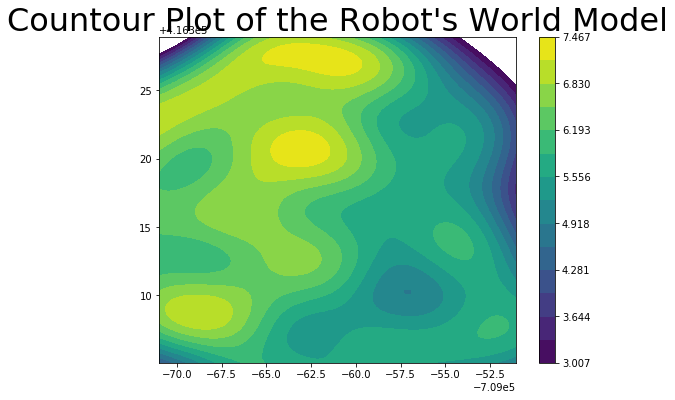

In [18]:
fh_d = fh_df.loc[fh_df['p'].drop_duplicates(subset=['Longitude']).dropna().index]
fh_d = fh_d.loc[fh_d['gga'].dropna(subset=['CO2_ppm_adjusted']).index]
fh_d = fh_d[fh_d['p']['Latitude'] < 41.634]
fh_d = fh_d[fh_d['p']['Latitude'] > 41.6305]
fh_d = fh_d[fh_d['p']['Longitude'] > -70.9071]
fh_d = fh_d[fh_d['ctd']['Depth'] > 0.2]
fh_d = fh_d[fh_d['ctd']['Depth'] < 0.5]
fh_d = fh_d[fh_d['gga']['CH4_ppm_adjusted'] < 8.5]


# ctd_fh = ctd_df.drop(ctd_df[ctd_df.Julian_Date > (0.205+2458207)].index)
# ctd_nb = ctd_df.drop(ctd_df[ctd_df.Julian_Date < (0.231+2458207)].index)
# fh_d = fh_d.dropna()

xv = fh_d['p']['Longitude'][:]
yv = fh_d['p']['Latitude'][:]
z = fh_d['gga']['CH4_ppm_adjusted'][:]

# plt.scatter(xv*100, yv*100)

ranges = [min(xv)*10000, max(xv)*10000, min(yv)*10000, max(yv)*10000]

points = []
for x,y in zip(xv, yv):
    points.append([x*10000,y*10000])

xvals = np.array(points)
zvals = np.reshape(np.array(z), (len(z), 1))
print xvals.shape, zvals.shape

kern = GPy.kern.RBF(input_dim = 2, lengthscale=0.001, variance=np.var(z))
mod = GPy.models.GPRegression(xvals, zvals, kern)
mod.initialize_parameter()
mod.optimize_restarts(num_restarts = 2, messages = True)
print kern

xc = np.linspace(ranges[0], ranges[1], 100)
yc = np.linspace(ranges[2], ranges[3], 100)
xc, yc = np.meshgrid(xc, yc, sparse = False, indexing= 'xy')
data = np.vstack([xc.ravel(), yc.ravel()]).T
obs, var = mod.predict(data, full_cov=False, include_likelihood=True)

fig2, ax2 = plt.subplots(figsize=(8, 6))
ax2.set_xlim(ranges[0:2])
ax2.set_ylim(ranges[2:])       
ax2.set_title('Countour Plot of the Robot\'s World Model')     
plot = ax2.contourf(xc, yc, obs.reshape(xc.shape), cmap = 'viridis', levels=np.linspace(min(z), max(z), 15), vmin=min(z), vmax=max(z))
# ax2.scatter(xc, yc, c=obs.reshape(xc.shape), cmap = 'viridis', levels=np.linspace(min(z), max(z), 15), vmin=min(z), vmax=max(z))
ax2.scatter(xv, yv, c=z, cmap='viridis', vmin=min(z), vmax=max(z))
ax2.plot(-70.90668, 41.63118, 'r*', markersize=10)
cbar = fig2.colorbar(plot)

(1458, 2) (1458, 1)
19.965 23.853
World max value 7.467374396955659 at location [-709064.919  416322.422]
[ 0 ] Current Location:   (-709061.0165000001, 416316.99750000006, 0)
Number of rollouts: 4881 	 Size of tree: 18484
Current predicted max and value: 	[[0. 0.]] 	0.0
[ 1 ] Current Location:   (-709062.7732826921, 416315.2188166181, -2.35)
Starting global optimization 0 of 2
Max val in optmization 	 	[12.05904676]
Starting global optimization 1 of 2
Max val in optmization 	 	[11.8962821]
Number of rollouts: 3274 	 Size of tree: 10000
Current predicted max and value: 	[-709062.77328269  416315.21881662] 	6.319338982622379
[ 2 ] Current Location:   (-709065.2664043884, 416315.404138521, -3.2157894736842105)
Starting global optimization 0 of 2
Max val in optmization 	 	[11.56020758]
Starting global optimization 1 of 2
Max val in optmization 	 	[12.79127607]
Number of rollouts: 3178 	 Size of tree: 9660
Current predicted max and value: 	[-709065.26640439  416315.40413852] 	6.65157603824

Max val in optmization 	 	[13.90863827]
Starting global optimization 1 of 2
Max val in optmization 	 	[15.7238491]
Number of rollouts: 762 	 Size of tree: 2744
Current predicted max and value: 	[-709062.13303655  416325.76721735] 	6.950659697180498
[ 23 ] Current Location:   (-709067.3191021367, 416308.0408042524, -9.771052631578945)
Starting global optimization 0 of 2
Max val in optmization 	 	[14.61918717]
Starting global optimization 1 of 2
Max val in optmization 	 	[15.74256658]
Number of rollouts: 766 	 Size of tree: 2712
Current predicted max and value: 	[-709062.13303655  416325.76721735] 	6.950659697180498
[ 24 ] Current Location:   (-709069.2030155809, 416309.68423667713, -10.142105263157893)
Starting global optimization 0 of 2
Max val in optmization 	 	[15.59137017]
Starting global optimization 1 of 2
Max val in optmization 	 	[13.32067881]
Number of rollouts: 785 	 Size of tree: 2520
Current predicted max and value: 	[-709068.45003219  416309.02555127] 	7.025876227647854
[ 2

Max val in optmization 	 	[17.41490283]
Starting global optimization 1 of 2
Max val in optmization 	 	[14.53549539]
few paths available!
Number of rollouts: 746 	 Size of tree: 3045
Current predicted max and value: 	[-709068.4606437   416308.31146559] 	7.087631420246531
[ 44 ] Current Location:   (-709053.0854363679, 416324.5107856905, -8.16315789473684)
Starting global optimization 0 of 2
Max val in optmization 	 	[17.76685788]
Starting global optimization 1 of 2
Max val in optmization 	 	[15.96423188]
Number of rollouts: 734 	 Size of tree: 3173
Current predicted max and value: 	[-709068.4606437   416308.31146559] 	7.087631420246531
[ 45 ] Current Location:   (-709054.1341092775, 416322.2413617264, -8.286842105263155)
Starting global optimization 0 of 2
Max val in optmization 	 	[13.09647884]
Starting global optimization 1 of 2
Max val in optmization 	 	[14.72678763]
Number of rollouts: 716 	 Size of tree: 2877
Current predicted max and value: 	[-709068.4606437   416308.31146559] 	7.

Max val in optmization 	 	[18.97904344]
Starting global optimization 1 of 2
Max val in optmization 	 	[17.53351065]
Number of rollouts: 676 	 Size of tree: 2984
Current predicted max and value: 	[-709068.4606437   416308.31146559] 	7.087631420246531
[ 62 ] Current Location:   (-709058.1544548796, 416309.3549667703, 0.7421052631578999)
Starting global optimization 0 of 2
Max val in optmization 	 	[12.7927816]
Starting global optimization 1 of 2
Max val in optmization 	 	[18.53885539]
Number of rollouts: 631 	 Size of tree: 2831
Current predicted max and value: 	[-709068.4606437   416308.31146559] 	7.087631420246531
[ 63 ] Current Location:   (-709057.6326449512, 416311.7999032518, 1.3605263157894791)
Starting global optimization 0 of 2
Max val in optmization 	 	[15.26515263]
Starting global optimization 1 of 2
Max val in optmization 	 	[22.13519449]
Number of rollouts: 668 	 Size of tree: 2978
Current predicted max and value: 	[-709068.4606437   416308.31146559] 	7.087631420246531
[ 64 

Current predicted max and value: 	[-709063.42850917  416320.28498148] 	7.260733673184854
[ 83 ] Current Location:   (-709065.497374385, 416319.83598429745, 1.8552631578947438)
Starting global optimization 0 of 2
Max val in optmization 	 	[15.9236938]
Starting global optimization 1 of 2
Max val in optmization 	 	[8.83481068]
Number of rollouts: 615 	 Size of tree: 2301
Current predicted max and value: 	[-709063.42850917  416320.28498148] 	7.260733673184854
[ 84 ] Current Location:   (-709063.6547559606, 416321.5255870146, 0.7421052631579017)
Starting global optimization 0 of 2
Max val in optmization 	 	[54.06164749]
Starting global optimization 1 of 2
Max val in optmization 	 	[12.20585559]
Number of rollouts: 638 	 Size of tree: 2852
Current predicted max and value: 	[-709063.42850917  416320.28498148] 	7.260733673184854
[ 85 ] Current Location:   (-709062.5501790053, 416319.2828409858, -1.1131578947368352)
Starting global optimization 0 of 2
Max val in optmization 	 	[13.65898788]
Sta

Number of rollouts: 609 	 Size of tree: 2730
Current predicted max and value: 	[-709063.3012052   416320.91384379] 	7.270744086507934
[ 105 ] Current Location:   (-709061.9487568564, 416309.37480029016, 0.37105263157895374)
Starting global optimization 0 of 2
Max val in optmization 	 	[10.08569268]
Starting global optimization 1 of 2
Max val in optmization 	 	[68.66163154]
Number of rollouts: 610 	 Size of tree: 2726
Current predicted max and value: 	[-709063.3012052   416320.91384379] 	7.270744086507934
[ 106 ] Current Location:   (-709063.4726846562, 416311.35662875423, 2.2263157894736905)
Starting global optimization 0 of 2
Max val in optmization 	 	[11.18203091]
Starting global optimization 1 of 2
Max val in optmization 	 	[7.81104273]
Number of rollouts: 606 	 Size of tree: 2365
Current predicted max and value: 	[-709063.3012052   416320.91384379] 	7.270744086507934
[ 107 ] Current Location:   (-709065.6115076694, 416312.6510151409, 2.597368421052638)
Starting global optimization 

Max val in optmization 	 	[27.27273932]
Number of rollouts: 570 	 Size of tree: 2583
Current predicted max and value: 	[-709063.21137901  416320.65687817] 	7.284787279639119
[ 127 ] Current Location:   (-709059.0511028465, 416317.8654293311, -1.1131578947368357)
Starting global optimization 0 of 2
Max val in optmization 	 	[18.88481876]
Starting global optimization 1 of 2
Max val in optmization 	 	[30.26754958]
Number of rollouts: 555 	 Size of tree: 2511
Current predicted max and value: 	[-709063.21137901  416320.65687817] 	7.284787279639119
[ 128 ] Current Location:   (-709056.8508686273, 416316.6784291708, -0.4947368421052565)
Starting global optimization 0 of 2
Max val in optmization 	 	[26.34821057]
Starting global optimization 1 of 2
Max val in optmization 	 	[26.21668622]
Number of rollouts: 565 	 Size of tree: 2556
Current predicted max and value: 	[-709063.21137901  416320.65687817] 	7.284787279639119
[ 129 ] Current Location:   (-709054.8138814631, 416315.22905575694, -0.6184

Max val in optmization 	 	[37.25811992]
Number of rollouts: 540 	 Size of tree: 2027
Current predicted max and value: 	[-709063.05237343  416320.43158912] 	7.300702389717247
[ 149 ] Current Location:   (-709061.8074764955, 416328.35382191336, 1.8552631578947434)
Starting global optimization 0 of 2
Max val in optmization 	 	[35.38129697]
Starting global optimization 1 of 2
Max val in optmization 	 	[16.67147608]
Number of rollouts: 528 	 Size of tree: 2273
Current predicted max and value: 	[-709063.05237343  416320.43158912] 	7.300702389717247


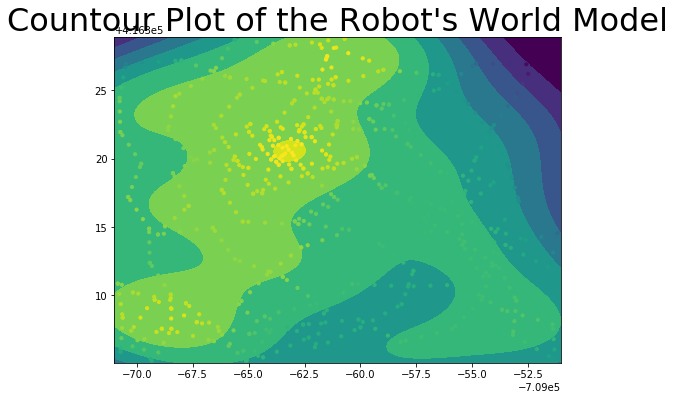

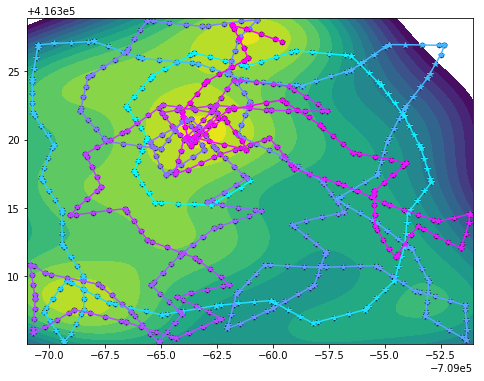

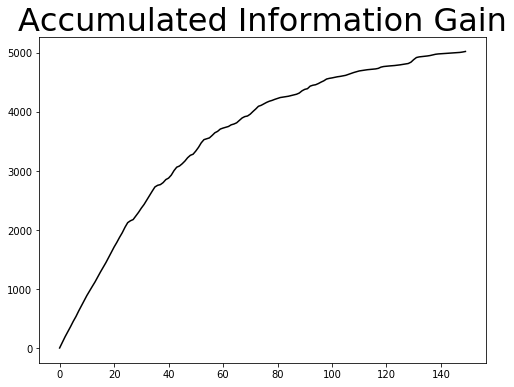

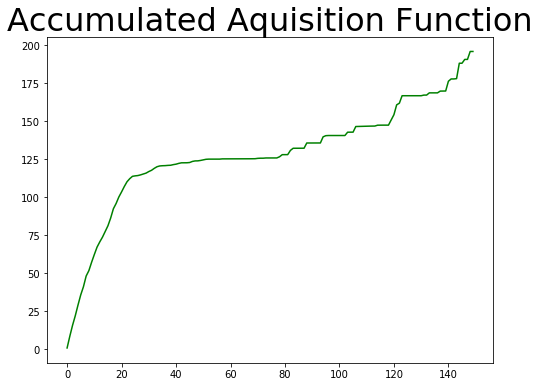

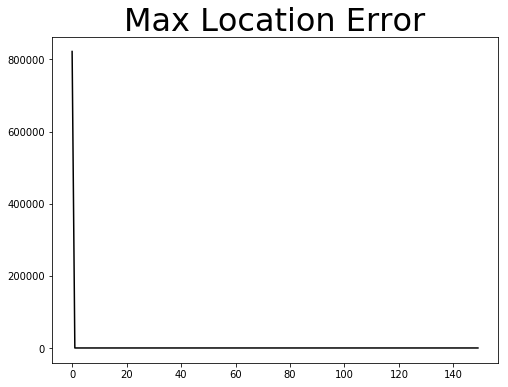

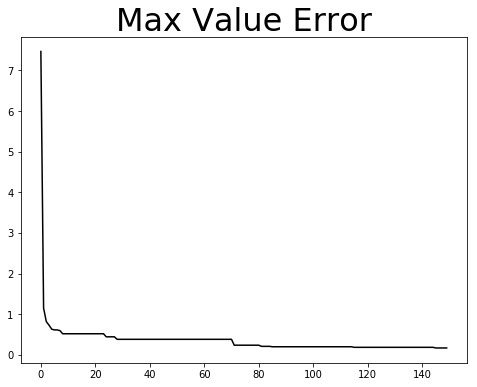

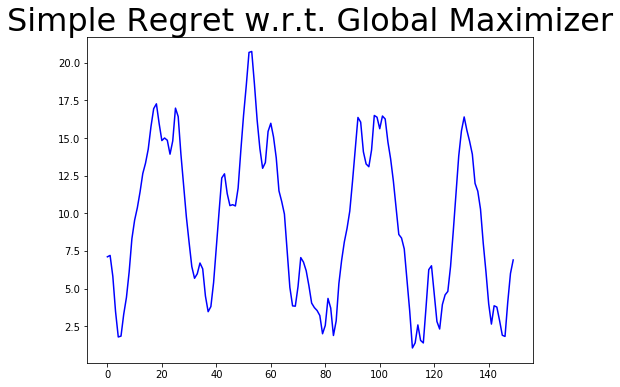

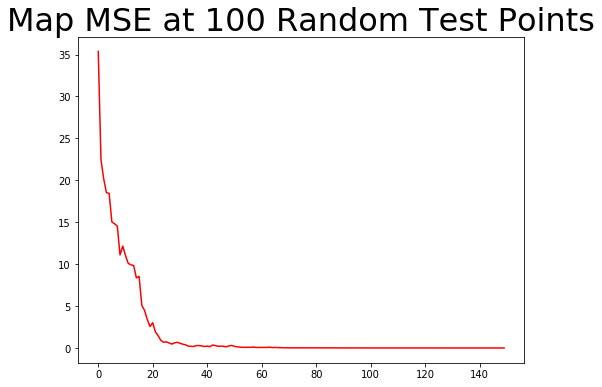

In [23]:
reload(ipp_library)
from ipp_library import *

# Create a random enviroment sampled from a GP with an RBF kernel and specified hyperparameters, mean function 0 
# The enviorment will be constrained by a set of uniformly distributed  sample points of size NUM_PTS x NUM_PTS
''' Options include mean, info_gain, hotspot_info, and mes'''
xv = fh_d['p']['Longitude'][:]
yv = fh_d['p']['Latitude'][:]
z = fh_d['gga']['CH4_ppm_adjusted'][:]

# plt.scatter(xv*100, yv*100)

points = []
for x,y in zip(xv, yv):
    points.append([x*10000,y*10000])

xvals = np.array(points)
zvals = np.reshape(np.array(z), (len(z), 1))
print xvals.shape, zvals.shape
print max(xv)*10000 - min(xv)*10000, max(yv)*10000 - min(yv)*10000

ranges = (min(xv)*10000, max(xv)*10000, min(yv)*10000, max(yv)*10000)

reward_function = 'mes'

gp_world = GPModel(ranges, 4.1050775778369463, 13.183938289650506)
gp_world.add_data(xvals, zvals)

world = Environment(ranges = ranges, # x1min, x1max, x2min, x2max constraints
                    NUM_PTS = 20, 
                    variance = 13., 
                    lengthscale = 0.0004, 
                    visualize = True,
                    seed = None,
                    model = gp_world)

evaluation = Evaluation(world = world, reward_function = reward_function)

# Gather some prior observations to train the kernel (optional)
#x1observe = np.linspace(ranges[0]+0.5, ranges[1]-0,5, 15)
#x2observe = np.linspace(ranges[2]+0.5, ranges[3]-0.5, 15)
# x1observe = np.linspace(0., 10., 20)
# x2observe = np.linspace(0., 10., 20)
# x1observe, x2observe = np.meshgrid(x1observe, x2observe, sparse = False, indexing = 'xy')  
# data = np.vstack([x1observe.ravel(), x2observe.ravel()]).T

# # TODO: make the edges less appealing!

# observations = world.sample_value(data)

# Create the point robot
#obot.__class__ = Nonmyopic_Robot
robot = Nonmyopic_Robot(sample_world = world.sample_value, 
              start_loc = ((min(xv)*10000+max(xv)*10000)/2, (min(yv)*10000+max(yv)*10000)/2, 0), 
              extent = ranges,
              kernel_file = None,
              kernel_dataset = None,
              prior_dataset =  None, 
#               prior_dataset =  (data, observations), 
              init_lengthscale = 4.1050775778369463, 
              init_variance = 13.183938289650506, 
              noise = 0.0001,
              path_generator = 'dubins',
              frontier_size = 20, 
              horizon_length = 2.5, 
              turning_radius = 0.05,
              sample_step = 0.75,
              evaluation = evaluation, 
              f_rew = reward_function, 
              create_animation = True,
              computation_budget = 10.0,
              rollout_length = 5) 

robot.planner(T = 150)
robot.visualize_world_model(screen = True)
robot.visualize_trajectory(screen = True)
robot.plot_information()
